The dataset that I will be preparing comes from a Kaggle competition based on predicting home sale prices in Ames, Iowa.  When preparing this data I will try to focus on some obvious factors that play into the home buying process, some less obviouse factors, and how one might be able to predict future home sale prices given existing trends in that data.

In [1]:
# importing necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
# loading in Home Price dataset
df = pd.read_csv('train.csv')

## Exploring the data

In [3]:
df.shape

(1460, 81)

In [4]:
# Get info on each col and what type of data they contain
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Break down between numerical data and categorical
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


We see from this info that we have 38 numerical features and 43 categorical ones. We also note that we should expect to have 1,460 observations for each variable. There are also a few variables that have a lot of missing data that will require some handling. For this analysis, however, the variable I want to focus on as my outcome of interest is 'SalePrice'. As for continuous variables I believe will be useful for predicting the 'SalePrice' are, espcially considering we're looking at homes in Ames, Iowa: 'GrLivArea', 'TotalBsmtSF', 'Fireplaces', and 'YearBuilt'. Categorical variables of interest are: 'OverallQual', 'KitchenQual' and 'Neighborhood'. These variables may change based on analysis and usefulness for modeling.

### Dealing with Missing Values

In [7]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*40)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
--------------------------------------------------------------------------------
Missing Data Percentage
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64


#### Over 50% Missing
PoolQC, MiscFeature, Alley, Fence will all be removed as they are missing over half of their observations.

In [8]:
# Features with over 50% of its observations missings will be removed
df = df.drop(['PoolQC','MiscFeature','Alley','Fence'],axis = 1)

In [9]:
# Functions to address missing data

# Explore features
def feat_explore(column):
    return df[column].value_counts()

# Function to impute missing values
def feat_impute(column, value):
    df.loc[df[column].isnull(),column] = value

#### Fireplace Qu
FireplaceQu is missing 690 observations. However, these nulls may be attributed to homes that do not have fireplaces at all. If this assumption proves to be true, we can impute these nulls with '0' as they do not have a fireplace.

In [10]:
# FireplaceQu missing data
print('FireplaceQu Missing Before:', df['FireplaceQu'].isnull().sum())
print('--'*40)

# The null values may be homes that do not have fireplaces at all. Need to check this assumption
print(df[df['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']])
print(df[df['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']].shape)
print('--'*40)

# Impute the nulls with None 
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
print('FireplaceQu Missing After:', df['FireplaceQu'].isnull().sum())

print('--'*40)
# Cross check columns
print('Confirm Imputation')
print(pd.crosstab(df.FireplaceQu,df.Fireplaces,))

FireplaceQu Missing Before: 690
--------------------------------------------------------------------------------
      Fireplaces FireplaceQu
0              0         NaN
5              0         NaN
10             0         NaN
12             0         NaN
15             0         NaN
17             0         NaN
18             0         NaN
19             0         NaN
26             0         NaN
29             0         NaN
30             0         NaN
31             0         NaN
32             0         NaN
36             0         NaN
38             0         NaN
39             0         NaN
42             0         NaN
43             0         NaN
44             0         NaN
47             0         NaN
48             0         NaN
49             0         NaN
50             0         NaN
52             0         NaN
56             0         NaN
57             0         NaN
59             0         NaN
60             0         NaN
61             0         NaN
63             0 

#### Lot Frontage
LotFrontage is missing 259 observations. First, I will check to see if there are other variables that are strongly correlated with LotFrontage I can use for imputation. Otherwise, I will impute with the median LotFrontage value.

In [11]:
# Lot Frontage
print('LotFrontage Missing Before:', df['LotFrontage'].isnull().sum())

# Check to see if there is a strong correlation with other variables we can use to impute
corr_lf = df.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict_lf = corr_lf['LotFrontage'].to_dict()
del cor_dict_lf['LotFrontage']
print("Numeric features by Correlation with LotFrontage:\n")
for ele in sorted(cor_dict_lf.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

# Nothing highly correlated to LotFrontage so will impute with the mean
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
print('LotFrontage Missing After:', df['LotFrontage'].isnull().sum())

LotFrontage Missing Before: 259
Numeric features by Correlation with LotFrontage:

1stFlrSF: 	0.4571810019946558
LotArea: 	0.4260950187718087
GrLivArea: 	0.40279741408532066
TotalBsmtSF: 	0.39207457637917215
MSSubClass: 	-0.3863468853449303
TotRmsAbvGrd: 	0.35209594766022567
SalePrice: 	0.35179909657067854
GarageArea: 	0.34499672410648324
GarageCars: 	0.28569092468510454
Fireplaces: 	0.2666394825603015
BedroomAbvGr: 	0.26316991588106087
OverallQual: 	0.25164577548061245
BsmtFinSF1: 	0.23363316701975517
PoolArea: 	0.20616677527607583
FullBath: 	0.1987686778973781
MasVnrArea: 	0.19345806055826895
OpenPorchSF: 	0.15197222768060648
BsmtUnfSF: 	0.13264374162493386
YearBuilt: 	0.12334946703331695
BsmtFullBath: 	0.10094856694926896
YearRemodAdd: 	0.08886557249206857
WoodDeckSF: 	0.08852093328940891
2ndFlrSF: 	0.0801772706242048
GarageYrBlt: 	0.07024978191661561
3SsnPorch: 	0.07002922773085192
OverallCond: 	-0.05921345000524757
HalfBath: 	0.05353185497960573
BsmtFinSF2: 	0.04989967669098971
Sc

#### Garage Features
GarageYrBlt, GarageType, GarageFinish,GarageQual, and GarageCond are all missing 81 observations. These null values are assumed to be in the same rows for each column and associated with homes that do not have garages at all. If these assumptions are correct, the nulls can be inputed with zero as these are properties without garages

In [12]:
# Garage Features
print('Garage Features Missing Before')
print(df[['GarageYrBlt', 'GarageType', 'GarageFinish','GarageQual','GarageCond']].isnull().sum())

# Assumptions check
print('--'*40)
print('Assumption Check')
null_garage = ['GarageYrBlt','GarageType','GarageQual','GarageCond','GarageFinish']
print(df[(df['GarageYrBlt'].isnull())|
                 (df['GarageType'].isnull())|
                 (df['GarageQual'].isnull())|
                 (df['GarageCond'].isnull())|
                 (df['GarageFinish'].isnull())]
                 [['GarageCars','GarageYrBlt','GarageType','GarageQual','GarageCond','GarageFinish']])

# Impute null garage features
for cols in null_garage:
   if df[cols].dtype ==np.object:
         feat_impute(cols, 'None')
   else:
         feat_impute(cols, 0)
        
# Garage Features After
print('--'*40)
print('Garage Features Missing After')
print(df[['GarageYrBlt', 'GarageType', 'GarageFinish','GarageQual','GarageCond']].isnull().sum())
print('--'*40)
# Cross check columns
print('Confirm Imputation')
for cols in null_garage:
    print(pd.crosstab(df[cols],df.GarageCars))

Garage Features Missing Before
GarageYrBlt     81
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64
--------------------------------------------------------------------------------
Assumption Check
      GarageCars  GarageYrBlt GarageType GarageQual GarageCond GarageFinish
39             0          NaN        NaN        NaN        NaN          NaN
48             0          NaN        NaN        NaN        NaN          NaN
78             0          NaN        NaN        NaN        NaN          NaN
88             0          NaN        NaN        NaN        NaN          NaN
89             0          NaN        NaN        NaN        NaN          NaN
99             0          NaN        NaN        NaN        NaN          NaN
108            0          NaN        NaN        NaN        NaN          NaN
125            0          NaN        NaN        NaN        NaN          NaN
127            0          NaN        NaN        NaN        NaN          NaN
140

#### Basement Features Part 1
BsmtFinType2 and 'BsmtExposure are both missing 38 observations. It is suspected that these observations are in the same rows for both columns and associated with homes that do not have basements. If these assumptions are true, we can impute the nulls with zero as we have for other missing values previously.

In [13]:
# BsmtFinType2 and BsmtExposure are both missing 38 observations
# Check that data is missing in the same rows
# Confirm if all nulls correspond to homes without basements
print('Assumption Check')
null_basement = ['BsmtFinType2','BsmtExposure']
print(df[df['BsmtFinType2'].isnull()|(df['BsmtExposure'].isnull())][['TotalBsmtSF','BsmtFinType2','BsmtExposure']])
print('entries',df[df['BsmtFinType2'].isnull()|(df['BsmtExposure'].isnull())][['TotalBsmtSF','BsmtFinType2','BsmtExposure']].shape)

Assumption Check
      TotalBsmtSF BsmtFinType2 BsmtExposure
17              0          NaN          NaN
39              0          NaN          NaN
90              0          NaN          NaN
102             0          NaN          NaN
156             0          NaN          NaN
182             0          NaN          NaN
259             0          NaN          NaN
332          3206          NaN           No
342             0          NaN          NaN
362             0          NaN          NaN
371             0          NaN          NaN
392             0          NaN          NaN
520             0          NaN          NaN
532             0          NaN          NaN
533             0          NaN          NaN
553             0          NaN          NaN
646             0          NaN          NaN
705             0          NaN          NaN
736             0          NaN          NaN
749             0          NaN          NaN
778             0          NaN          NaN
868            

#### Basement Features Part 1 (Continued...)
Most of the nulls are homes without basements; however, there are two exceptions that must be addressed before we can impute the nulls with zero.

1. BsmTfinType2 at index 332 is null, but has a basement of 3206 sq feet.
2. BsmtExposure at index 948 is null, but has a basement of 936 sq feet.

These two exceptions will be imputed with that column's most frequent value. The remaning null values will be imputed with 'None' as they corresond to homes without basements.

In [14]:
# Impute the only null BsmtFinType2 with a basement at index 332 with most frequent value
df.iloc[332, df.columns.get_loc('BsmtFinType2')] = df['BsmtFinType2'].mode()[0]


# Impute the only null BsmtExposure with a basement at index 948 with most frequent value
df.iloc[948, df.columns.get_loc('BsmtExposure')] = df['BsmtExposure'].mode()[0]

# Impute the remaining nulls as None
for cols in null_basement:
   if df[cols].dtype ==np.object:
         feat_impute(cols, 'None')
   else:
         feat_impute(cols, 0)

# Basement Features After
print('--'*40)
print('Basement Features Missing After')
print(df[['BsmtFinType2', 'BsmtExposure']].isnull().sum())
print('--'*40)
# Cross check columns
print('Confirm Imputation')
for cols in null_basement:
    print(pd.crosstab(df.TotalBsmtSF,df[cols]))

--------------------------------------------------------------------------------
Basement Features Missing After
BsmtFinType2    0
BsmtExposure    0
dtype: int64
--------------------------------------------------------------------------------
Confirm Imputation
BsmtFinType2  ALQ  BLQ  GLQ  LwQ  None  Rec  Unf
TotalBsmtSF                                     
0               0    0    0    0    37    0    0
105             0    0    0    0     0    0    1
190             0    0    0    0     0    0    1
264             0    0    0    0     0    0    3
270             0    0    0    0     0    0    1
290             0    0    0    0     0    0    1
319             0    0    0    0     0    0    1
360             0    0    0    0     0    0    1
372             0    0    0    0     0    0    1
384             0    0    0    0     0    0    7
408             0    0    0    0     0    0    1
420             0    0    0    0     0    0    1
440             0    0    0    0     0    0    3
458

#### Basement Features Part 2
There is another set of basement features that are missing the same number of observations. BsmtFinType1, BsmtCond, BsmtQual all have 37 missing values. It is assumed that these observations are in the same rows and correspond to homes that do not have basements. If these assumptions are true, we will impute nulls with 'None', otherwise impute using the most frequent value for each feature.

In [15]:
# Basement Features Part 2
print('Basement Features Part 2 Missing Before')
print(df[['BsmtFinType1', 'BsmtCond','BsmtQual']].isnull().sum())
print('--'*40)

# Check assumptions
null_basement2 = ['BsmtFinType1', 'BsmtCond','BsmtQual']
print('Assumption Check')
print(df[(df['BsmtFinType1'].isnull())|
                 (df['BsmtCond'].isnull())|
                 (df['BsmtQual'].isnull())]
                 [['TotalBsmtSF','BsmtFinType1', 'BsmtCond','BsmtQual']])
print('entries',df[(df['BsmtFinType1'].isnull())|
                 (df['BsmtCond'].isnull())|
                 (df['BsmtQual'].isnull())]
                 [['TotalBsmtSF','BsmtFinType1', 'BsmtCond','BsmtQual']].shape)

# NA in all. NA means No basement
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#   features[col] = features[col].fillna('None')

# Impute nulls to None or 0
for cols in null_basement2:
    if df[cols].dtype ==np.object:
        cols = feat_impute(cols, 'None')
    else:
        cols = feat_impute(cols, 0)    

print('--'*40)
print('Basement Features Part 2 Missing After')
print(df[['BsmtFinType1', 'BsmtCond','BsmtQual']].isnull().sum())

Basement Features Part 2 Missing Before
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
dtype: int64
--------------------------------------------------------------------------------
Assumption Check
      TotalBsmtSF BsmtFinType1 BsmtCond BsmtQual
17              0          NaN      NaN      NaN
39              0          NaN      NaN      NaN
90              0          NaN      NaN      NaN
102             0          NaN      NaN      NaN
156             0          NaN      NaN      NaN
182             0          NaN      NaN      NaN
259             0          NaN      NaN      NaN
342             0          NaN      NaN      NaN
362             0          NaN      NaN      NaN
371             0          NaN      NaN      NaN
392             0          NaN      NaN      NaN
520             0          NaN      NaN      NaN
532             0          NaN      NaN      NaN
533             0          NaN      NaN      NaN
553             0          NaN      NaN      NaN
646     

#### Masonry Features
MasVnrArea and MasVnrType are both missing 8 observations. Again, we'll check to see they are missing in the same rows and then impute with the most frequent value for each column.

In [16]:
# MasVnrArea and MasVnrType are each missing 8 observations
print('Masonry Features Missing Before')
print(df[['MasVnrArea', 'MasVnrType']].isnull().sum())
print('--'*40)

# Confirm that the missing values in these columns are the same rows
print('Check Assumptions')
print(df[(df['MasVnrArea'].isnull())|
                 (df['MasVnrType'].isnull())]
                 [['MasVnrArea','MasVnrType']])

print(df[(df['MasVnrArea'].isnull())|
                 (df['MasVnrType'].isnull())]
                 [['MasVnrArea','MasVnrType']].shape)

# Impute MasVnrArea with the most frequent values
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])

# Impute MasVnrType with the most frequent values
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])

print('Masonry Features Missing After')
print(df[['MasVnrArea', 'MasVnrType']].isnull().sum())
print('--'*40)

print('Confirm Imputation')
print(df[(df['MasVnrArea'].isnull())|
                 (df['MasVnrType'].isnull())]
                 [['MasVnrArea','MasVnrType']])

Masonry Features Missing Before
MasVnrArea    8
MasVnrType    8
dtype: int64
--------------------------------------------------------------------------------
Check Assumptions
      MasVnrArea MasVnrType
234          NaN        NaN
529          NaN        NaN
650          NaN        NaN
936          NaN        NaN
973          NaN        NaN
977          NaN        NaN
1243         NaN        NaN
1278         NaN        NaN
(8, 2)
Masonry Features Missing After
MasVnrArea    0
MasVnrType    0
dtype: int64
--------------------------------------------------------------------------------
Confirm Imputation
Empty DataFrame
Columns: [MasVnrArea, MasVnrType]
Index: []


#### Electrical
Electrical is only missing one observation, which can be imputed with the most frequent value in the column.

In [17]:
# Electrical is only missing one value
print('Electrical Feature Missing Before')
print(df[['Electrical']].isnull().sum())
print('--'*40)

# Impute Electrical with the most frequent value
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
print('Electrical Feature Missing After')
print(df[['Electrical']].isnull().sum())
print('--'*40)

Electrical Feature Missing Before
Electrical    1
dtype: int64
--------------------------------------------------------------------------------
Electrical Feature Missing After
Electrical    0
dtype: int64
--------------------------------------------------------------------------------


In [18]:
# Confirming no missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

### Encoding Categorical Variables

In [19]:
# Data Types
# Categorical Features
print('Categorical Features:\n ', df.select_dtypes(include=['object']).columns)
print('--'*40)

# Numeric Features
print('Numeric Features:\n ', df.select_dtypes(exclude=['object']).columns)

Categorical Features:
  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
--------------------------------------------------------------------------------
Numeric Features:
  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'Bsm

In [20]:
catcols = df.select_dtypes(['object'])
for cat in catcols:
    print('--'*40)
    print(cat)
    print(df[cat].value_counts())

--------------------------------------------------------------------------------
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
--------------------------------------------------------------------------------
Street
Pave    1454
Grvl       6
Name: Street, dtype: int64
--------------------------------------------------------------------------------
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
--------------------------------------------------------------------------------
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
--------------------------------------------------------------------------------
Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
--------------------------------------------------------------------------------
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Na

In [21]:
# Encode ordinal data
df['LotShape'] = df['LotShape'].map({'Reg':0,'IR1':1,'IR2':2,'IR3':3})
df['LandContour'] = df['LandContour'].map({'Low':0,'HLS':1,'Bnk':2,'Lvl':3})
df['Utilities'] = df['Utilities'].map({'NoSeWa':0,'NoSeWa':1,'AllPub':2})
df['BldgType'] = df['BldgType'].map({'Twnhs':0,'TwnhsE':1,'Duplex':2,'2fmCon':3,'1Fam':4})
df['HouseStyle'] = df['HouseStyle'].map({'1Story':0,'1.5Fin':1,'1.5Unf':2,'2Story':3,'2.5Fin':4,'2.5Unf':5,'SFoyer':6,'SLvl':7})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['LandSlope'] = df['LandSlope'].map({'Gtl':0,'Mod':1,'Sev':2})
df['Street'] = df['Street'].map({'Grvl':0,'Pave':1})
df['MasVnrType'] = df['MasVnrType'].map({'None':0,'BrkCmn':1,'BrkFace':2,'CBlock':3,'Stone':4})
df['CentralAir'] = df['CentralAir'].map({'N':0,'Y':1})
df['GarageFinish'] = df['GarageFinish'].map({'None':0,'Unf':1,'RFn':2,'Fin':3})
df['PavedDrive'] = df['PavedDrive'].map({'N':0,'P':1,'Y':2})
df['BsmtExposure'] = df['BsmtExposure'].map({'None':0,'No':1,'Mn':2,'Av':3,'Gd':4})
df['ExterQual'] = df['ExterQual'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['ExterCond'] = df['ExterCond'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['BsmtCond'] = df['BsmtCond'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['BsmtQual'] = df['BsmtQual'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['HeatingQC'] = df['HeatingQC'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['KitchenQual'] = df['KitchenQual'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['FireplaceQu'] = df['FireplaceQu'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageQual'] = df['GarageQual'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
df['GarageCond'] = df['GarageCond'].map({'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

# Encode Categorical Variables
df['Foundation'] = df['Foundation'].map({'BrkTil':0,'CBlock':1,'PConc':2,'Slab':3,'Stone':4,'Wood':5})
df['Heating'] = df['Heating'].map({'Floor':0,'GasA':1,'GasW':2,'Grav':3,'OthW':4,'Wall':5})
df['Electrical'] = df['Electrical'].map({'SBrkr':0,'FuseA':1,'FuseF':2,'FuseP':3,'Mix':4})
df['Functional'] = df['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
df['GarageType'] = df['GarageType'].map({'None':0,'Detchd':1,'CarPort':2,'BuiltIn':3,'Basment':4,'Attchd':5,'2Types':6})
df['SaleType'] = df['SaleType'].map({'Oth':0,'ConLD':1,'ConLI':2,'ConLw':3,'Con':4,'COD':5,'New':6,'VWD':7,'CWD':8,'WD':9})
df['SaleCondition'] = df['SaleCondition'].map({'Partial':0,'Family':1,'Alloca':2,'AdjLand':3,'Abnorml':4,'Normal':5})
df['MSZoning'] = df['MSZoning'].map({'A':0,'FV':1,'RL':2,'RP':3,'RM':4,'RH':5,'C (all)':6,'I':7})
df['LotConfig'] = df['LotConfig'].map({'Inside':0,'Corner':1,'CulDSac':2,'FR2':3,'FR3':4})
df['Neighborhood'] = df['Neighborhood'].map({'Blmngtn':0,'Blueste':1,'BrDale':2,'BrkSide':3, 'ClearCr':4,'CollgCr':5,'Crawfor':6,'Edwards':7,'Gilbert':8,
                                                             'IDOTRR':9,'MeadowV':10,'Mitchel':11, 'NAmes':12,'NoRidge':13,'NPkVill':14,'NridgHt':15, 'NWAmes':16,
                                                             'OldTown':17,'SWISU':18,'Sawyer':19, 'SawyerW':20,'Somerst':21,'StoneBr':22,'Timber':23,'Veenker':24})
df['Condition1'] = df['Condition1'].map({'Artery':0,'Feedr':1,'Norm':2,'RRNn':3, 'RRAn':4,'PosN':5,'PosA':6,'RRNe':7,'RRAe':8})
df['Condition2'] = df['Condition2'].map({'Artery':0,'Feedr':1,'Norm':2,'RRNn':3, 'RRAn':4,'PosN':5,'PosA':6,'RRNe':7,'RRAe':8})
df['RoofStyle'] = df['RoofStyle'].map({'Flat':0,'Gable':1,'Gambrel':2,'Hip':3,'Mansard':4,'Shed':5})
df['RoofMatl'] = df['RoofMatl'].map({'ClyTile':0,'CompShg':1,'Membran':2,'Metal':3,'Roll':4,'Tar&Grv':5,'WdShake':6,'WdShngl':7})
df['Exterior1st'] = df['Exterior1st'].map({'AsbShng':0,'AsphShn':1,'BrkComm':2,'BrkFace':3,'CBlock':4,'CemntBd':5,'HdBoard':6,'ImStucc':7,'MetalSd':8,
                                                           'Other':9,'Plywood':10,'PreCast':11,'Stone':12,'Stucco':13,'VinylSd':14,'Wd Sdng':15,'WdShing':16})
df['Exterior2nd'] = df['Exterior2nd'].map({'AsbShng':0,'AsphShn':1,'Brk Cmn':2,'BrkFace':3,'CBlock':4,'CmentBd':5,'HdBoard':6,'ImStucc':7,'MetalSd':8,
                                                           'Other':9,'Plywood':10,'PreCast':11,'Stone':12,'Stucco':13,'VinylSd':14,'Wd Sdng':15,'Wd Shng':16})

In [22]:
# Confirm encoding
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
MSZoning,1460.0,2.314384,0.866994,1.0,2.00,2.0,2.00,6.0
LotFrontage,1460.0,69.863699,22.027677,21.0,60.00,69.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
Street,1460.0,0.995890,0.063996,0.0,1.00,1.0,1.00,1.0
LotShape,1460.0,0.408219,0.582296,0.0,0.00,0.0,1.00,3.0
LandContour,1460.0,2.814384,0.606509,0.0,3.00,3.0,3.00,3.0
Utilities,1460.0,1.999315,0.026171,1.0,2.00,2.0,2.00,2.0
LotConfig,1460.0,0.416438,0.773448,0.0,0.00,0.0,1.00,4.0


## Univariate Analysis

We'll begin by looking at our target variable followed up by a few of our other variables exploring their descriptive statistics and distributions.

In [23]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

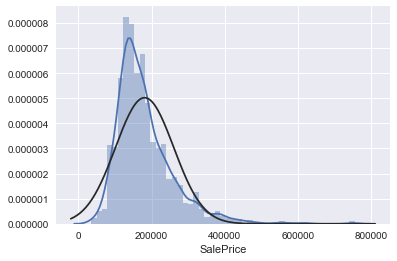

In [24]:
# Plotting 'SalePrice' distribution
from scipy.stats import norm

sns.distplot(df['SalePrice'], fit=norm)
plt.show()

So from this we see that the average sale price is \$180,921, the minimum isn't zero which is good for future processing, and a max sale price of $755,000. Looking at the distribution of sale price data reveals a non-normal distribution with a right skew,  and since most models expect a normally-distributed target variable we will do a log transfrom to improve this distribution.

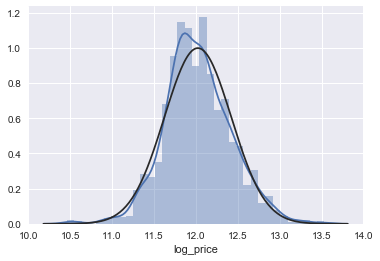

In [25]:
df['log_price'] = np.log1p(df['SalePrice'])

sns.distplot(df['log_price'], fit=norm)

### Numerical Variables

In [26]:
print(df[numerical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [27]:
# Dataframe with subset of numerical variables of interest
df_num = df.loc[:,['LotArea','OverallQual', 'YearBuilt', 'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'Fireplaces', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'log_price', 'SalePrice']]

df_num.describe()

,LotArea,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,GrLivArea,Fireplaces,GarageArea,GarageCars,WoodDeckSF,log_price,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,1971.267808,1057.429452,1162.626712,1515.463699,0.613014,472.980137,1.767123,94.244521,12.024057,180921.195890
std,9981.264932,1.382997,30.202904,438.705324,386.587738,525.480383,0.644666,213.804841,0.747315,125.338794,0.399449,79442.502883
min,1300.000000,1.000000,1872.000000,0.000000,334.000000,334.000000,0.000000,0.000000,0.000000,0.000000,10.460271,34900.000000
25%,7553.500000,5.000000,1954.000000,795.750000,882.000000,1129.500000,0.000000,334.500000,1.000000,0.000000,11.775105,129975.000000
50%,9478.500000,6.000000,1973.000000,991.500000,1087.000000,1464.000000,1.000000,480.000000,2.000000,0.000000,12.001512,163000.000000
75%,11601.500000,7.000000,2000.000000,1298.250000,1391.250000,1776.750000,1.000000,576.000000,2.000000,168.000000,12.273736,214000.000000
max,215245.000000,10.000000,2010.000000,6110.000000,4692.000000,5642.000000,3.000000,1418.000000,4.000000,857.000000,13.534474,755000.000000


Here we see a good amount of variance amongst these features, however we do notice a couple columns that don't appear to be continuous, 'OverallQual' and 'Fireplaces'. These will need to be recoded as categorical features.

In [28]:
df_num = df_num.drop(['OverallQual', 'Fireplaces'], axis=1)
df_num.head()

,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,GarageCars,WoodDeckSF,log_price,SalePrice
0,8450,2003,856,856,1710,548,2,0,12.247699,208500
1,9600,1976,1262,1262,1262,460,2,298,12.109016,181500
2,11250,2001,920,920,1786,608,2,0,12.317171,223500
3,9550,1915,756,961,1717,642,3,0,11.849405,140000
4,14260,2000,1145,1145,2198,836,3,192,12.429220,250000


### Bivariate Analysis

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


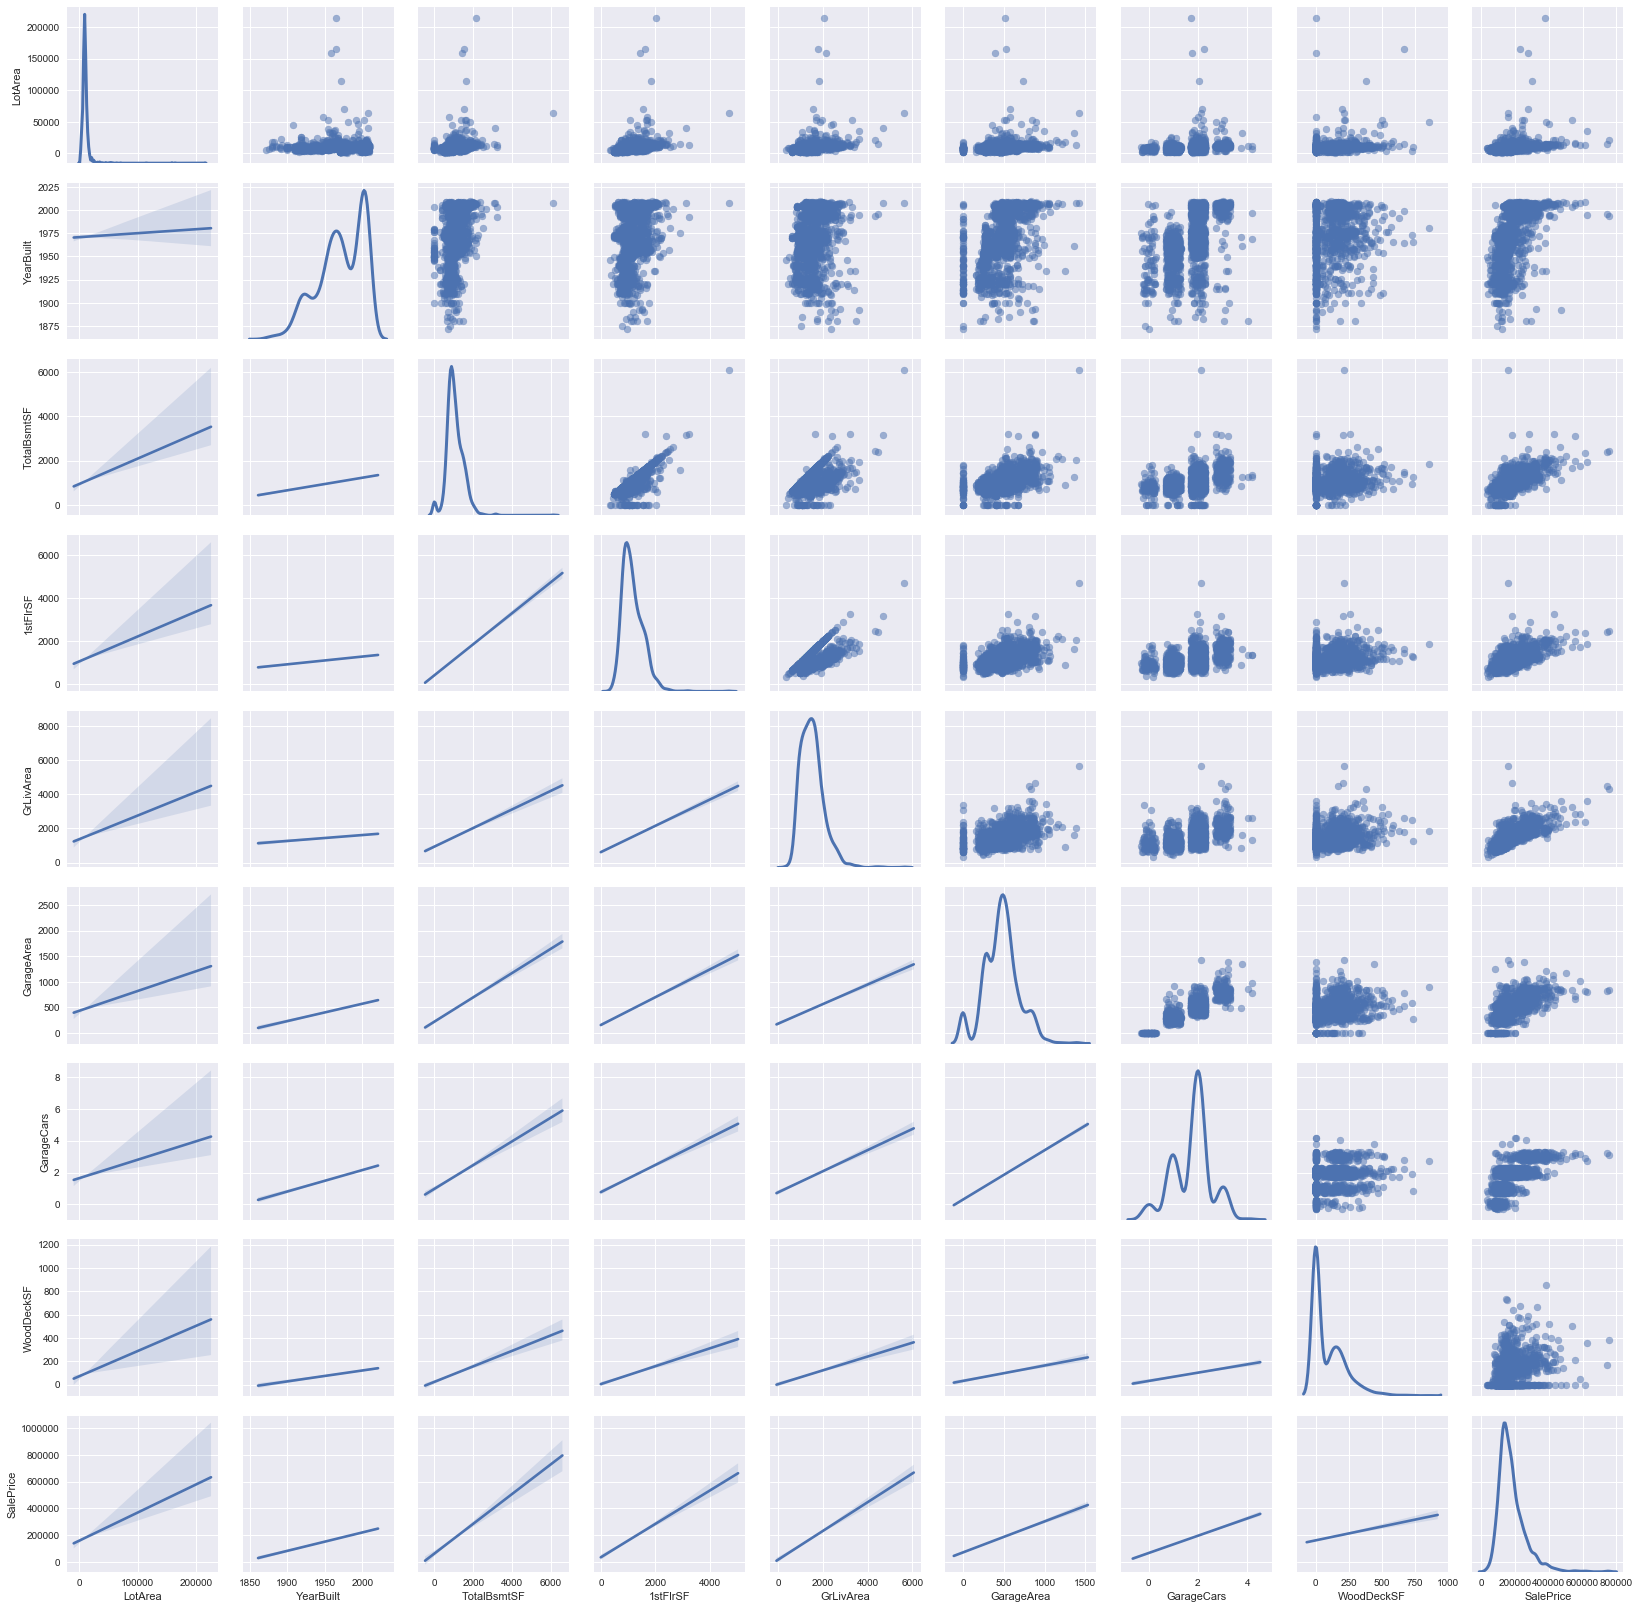

In [29]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df_num.drop(['log_price'], axis=1)
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Looking at these results, we have a some variables with strong positive correlations to our target variable which will be useful when choosing features and creating our model. We also note several of these variables exhibit non-normal distributions.

SalePrice      1.000000
log_price      0.948374
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
YearBuilt      0.522897
WoodDeckSF     0.324413
LotArea        0.263843
Name: SalePrice, dtype: float64


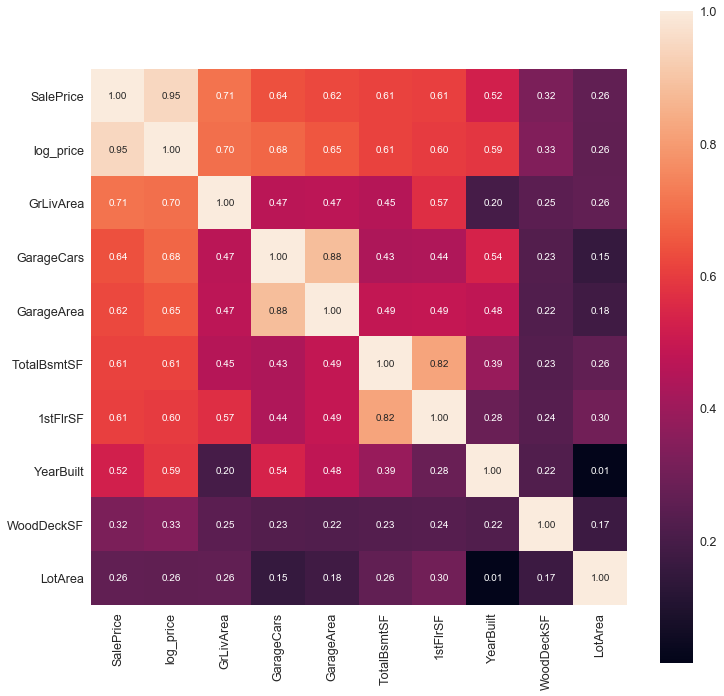

In [30]:
target = 'SalePrice'
nr_cols = 10
corrmat = df_num.corr()
print (corrmat.nlargest(nr_cols, target)[target])

cols = corrmat.nlargest(nr_cols, target)[target].index
cm = np.corrcoef(df_num[cols].values.T)

plt.figure(figsize=(12,12))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Exploring the relationships between our target variable 'SalePrice' and our numerical variables shows several possible variables on which to build features for our model. With 'GrLivArea' having the highest correlation to 'SalePrice'  several others exceed a possible cutoff from which to model.  We'll combine several of these variables, due to their collinearity, in hopes of capturing more variance in the outcome, eliminating redundant variables that don't add new information, and performing some transformations on data to hopefully reduce some of our multicollinearity.

### Relationship with categorical features

In [31]:
# Exploring the info contain within our categorical variables
for catg in catcols.columns:
    print(df[catg].value_counts())
    print('-'*50)

2    1151
4     218
1      65
5      16
6      10
Name: MSZoning, dtype: int64
--------------------------------------------------
1    1454
0       6
Name: Street, dtype: int64
--------------------------------------------------
0    925
1    484
2     41
3     10
Name: LotShape, dtype: int64
--------------------------------------------------
3    1311
2      63
1      50
0      36
Name: LandContour, dtype: int64
--------------------------------------------------
2    1459
1       1
Name: Utilities, dtype: int64
--------------------------------------------------
0    1052
1     263
2      94
3      47
4       4
Name: LotConfig, dtype: int64
--------------------------------------------------
0    1382
1      65
2      13
Name: LandSlope, dtype: int64
--------------------------------------------------
12    225
5     150
17    113
7     100
21     86
8      79
15     77
19     74
16     73
20     59
3      58
6      51
11     49
13     41
23     38
9      37
4      28
18     25
22     25


### Relation to SalePrice for Some categorical features

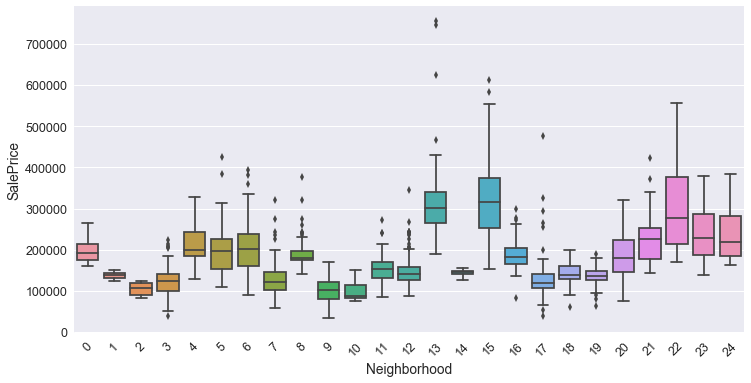

In [32]:
# Create boxplots for our categorical variables
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = df)
xt = plt.xticks(rotation=45)

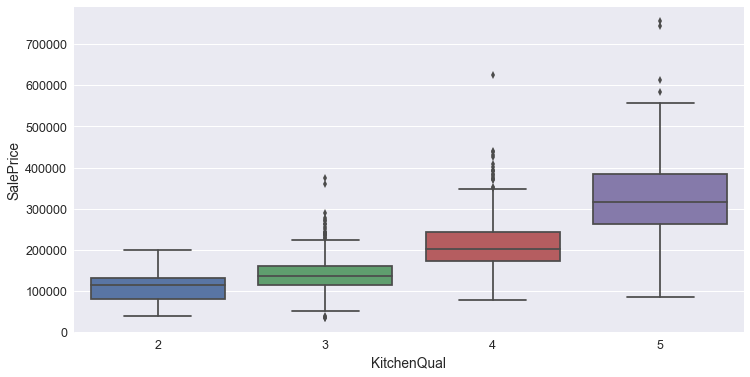

In [33]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'KitchenQual', y = 'SalePrice',  data = df);

In [34]:
# Descriptive statistics by group.
print(catcols.groupby('KitchenQual').describe())

# Test whether group differences are significant.
for col in df_num.columns:
    print(col)
    print(stats.ttest_ind(
        df[df['KitchenQual'] == 5][col],
        df[df['KitchenQual'] == 2][col]
     ))

            BldgType                   BsmtCond                 BsmtExposure  \
               count unique   top freq    count unique top freq        count   
KitchenQual                                                                    
Ex               100      3  1Fam   87      100      3  TA   91          100   
Fa                39      3  1Fam   32       39      5  TA   26           39   
Gd               586      5  1Fam  494      586      4  TA  545          586   
TA               735      5  1Fam  607      735      5  TA  649          735   

                   ...  SaleType      Street                   Utilities  \
            unique ...       top freq  count unique   top freq     count   
KitchenQual        ...                                                     
Ex               4 ...        WD   62    100      1  Pave  100       100   
Fa               5 ...        WD   37     39      2  Pave   38        39   
Gd               5 ...        WD  486    586      1  Pave  

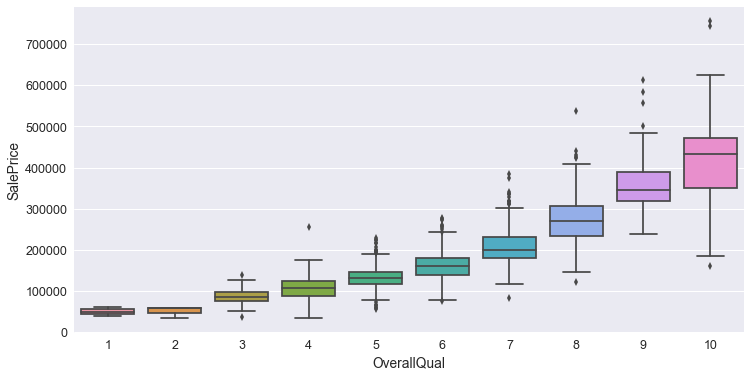

In [35]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'OverallQual', y = 'SalePrice',  data = df);

## Feature Engineering

### Standardization and Handling Outliers

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have a mean of 0 and a standard deviation of 1. 

In [36]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_price
0,1,60,2,65.0,8450,1,0,3,2,0,...,0,0,0,0,2,2008,9,5,208500,12.247699
1,2,20,2,80.0,9600,1,0,3,2,3,...,0,0,0,0,5,2007,9,5,181500,12.109016
2,3,60,2,68.0,11250,1,1,3,2,0,...,0,0,0,0,9,2008,9,5,223500,12.317171
3,4,70,2,60.0,9550,1,1,3,2,1,...,0,0,0,0,2,2006,9,4,140000,11.849405
4,5,60,2,84.0,14260,1,1,3,2,3,...,0,0,0,0,12,2008,9,5,250000,12.429220


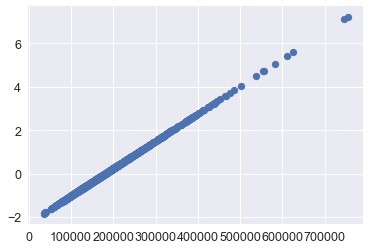

                Id    MSSubClass      MSZoning   LotFrontage       LotArea  \
count  1460.000000  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03   
mean      0.000000 -8.455945e-17 -1.508687e-16  2.798370e-16 -5.840077e-17   
std       1.000343  1.000343e+00  1.000343e+00  1.000343e+00  1.000343e+00   
min      -1.730865 -8.725628e-01 -1.516544e+00 -2.219047e+00 -9.237292e-01   
25%      -0.865432 -8.725628e-01 -3.627377e-01 -4.479400e-01 -2.969908e-01   
50%       0.000000 -1.631095e-01 -3.627377e-01 -3.922314e-02 -1.040633e-01   
75%       0.865432  3.098594e-01 -3.627377e-01  4.149067e-01  1.087080e-01   
max       1.730865  3.147673e+00  4.252488e+00  1.104155e+01  2.051827e+01   

             Street      LotShape   LandContour     Utilities     LotConfig  \
count  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03   
mean   5.961746e-16  4.866731e-18 -2.238696e-16  9.611794e-16 -2.311697e-17   
std    1.000343e+00  1.000343e+00  1.000343e+00  1.000343e+0

In [37]:
# Standardizing data
names = df.columns

df_scaled = pd.DataFrame(preprocessing.scale(df), columns=names)

plt.scatter(df['SalePrice'], df_scaled['SalePrice'])
plt.show()

print(df_scaled.describe())

In [38]:
# Remove outliers from the scaled dataset

df_scaled[(np.abs(stats.zscore(df_scaled)) < 3).all(axis=1)]

df_scaled.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_price
0,-1.730865,0.073375,-0.362738,-0.220875,-0.207142,0.064238,-0.701291,0.306146,0.02618,-0.538603,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.358449,0.394786,0.347273,0.560067
1,-1.728492,-0.872563,-0.362738,0.460320,-0.091886,0.064238,-0.701291,0.306146,0.02618,3.341462,...,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.358449,0.394786,0.007288,0.212763
2,-1.726120,0.073375,-0.362738,-0.084636,0.073480,0.064238,1.016637,0.306146,0.02618,-0.538603,...,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.358449,0.394786,0.536154,0.734046
3,-1.723747,0.309859,-0.362738,-0.447940,-0.096897,0.064238,1.016637,0.306146,0.02618,0.754752,...,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,0.358449,-0.283317,-0.515281,-0.437383
4,-1.721374,0.073375,-0.362738,0.641972,0.375148,0.064238,1.016637,0.306146,0.02618,3.341462,...,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.358449,0.394786,0.869843,1.014651


Let's create some features based on correlation to outcome variable, combine a few of our most correlated variables into single features that reflect a certain amount of variance in the outcome, and drop a few that feel redundant.

SalePrice       1.000000
log_price       0.948374
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
Name: SalePrice, dtype: float64


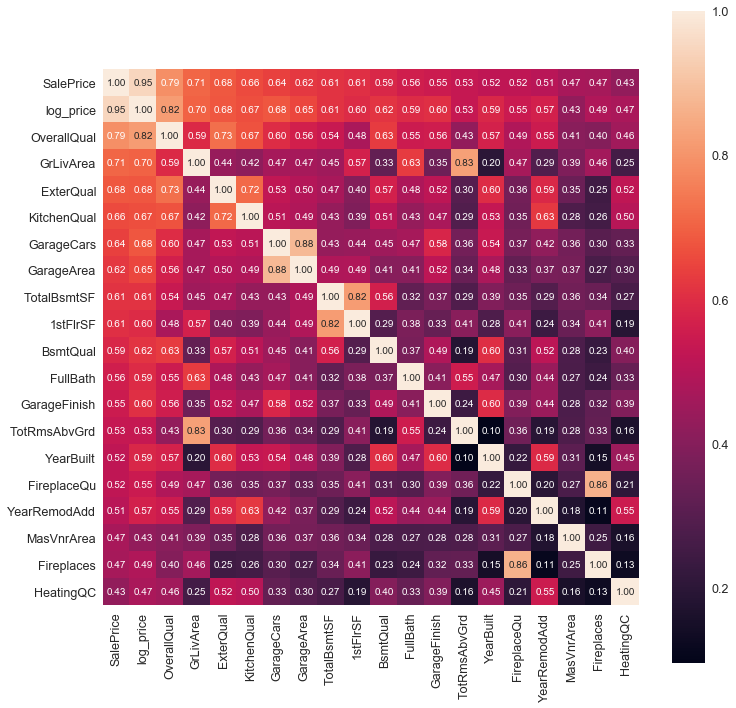

In [39]:
corrmat = df_scaled.corr()
nr_cols = 20
print (corrmat.nlargest(nr_cols, target)[target])

cols = corrmat.nlargest(nr_cols, target)[target].index
cm = np.corrcoef(df_scaled[cols].values.T)

plt.figure(figsize=(12,12))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at our scaled variables, we do see some nice reduction in multicollinearity without losing much correlation with our target variable 'SalePrice'. However, we clearly still have some redundant variables that can be dropped or combined to create our features. 

In [40]:
# Create dataframe to hold our features
features = pd.DataFrame()

#### Feature #1

We'll start by adding our Outcome variable, 'SalePrice', to the feature set.

In [65]:
features['LogPrice'] = df_scaled['log_price']

#### Feature # 2

Next, we will add 'OverallQual' due to it's high correlation to the outcome variable while maintaining correlation with other variables under 0.8

In [42]:
features['OverallQual'] = df_scaled['OverallQual']

#### Feature #3

Following the logic of our previous feature, we will next add 'GrLivArea'. Though there's a catch, the variable 'TotRmsAbvGrd' breaks our 0.8 cutoff for correlation with this variable so we will drop 'TotRmsAbvGrd'.

In [43]:
features['GrLivArea'] = df_scaled['GrLivArea']

df_scaled = df_scaled.drop(['TotRmsAbvGrd'], axis=1)

#### Feature #4

Next up we have our 'ExterQual' variable which has relatively high correlation to our 'OverallQual' feature so it may be removed once we perform some validation techniques.

In [44]:
features['ExterQual'] = df_scaled['ExterQual']

#### Feature #5

Our next variable in terms of correlation to the outcome is 'KitchenQual'

In [45]:
features['KitchenQual'] = df_scaled['KitchenQual']

#### Feature #6
Our two garage related variables are highly correlated, but the 'GarageCars' variable has slightly more correlation to the outcome so we will drop 'GarageArea'.

In [46]:
features['Garage'] = df_scaled['GarageCars']

df_scaled = df_scaled.drop(['GarageArea'], axis=1)

#### Feature #7
Examining our next variable 'TotalBsmtSF' we see strong correlation to '1stFlrSF' and that they both are correlated to the outcome variable at 0.61. To help us capture some of the info explained in both, we will combine these variables in hopes of not losing any crucial information.

In [47]:
# Scaling variables before combining
means = df[['TotalBsmtSF','1stFlrSF']].mean(axis=0)
stds = df[['TotalBsmtSF','1stFlrSF']].std(axis=0)

features['SquareFootage'] = ((df[['TotalBsmtSF','1stFlrSF']] - means) / stds).mean(axis=1)

# Check how well the composite correlates with each of the individual variables.
plotdf = df_scaled.loc[:, ['TotalBsmtSF','1stFlrSF']]
plotdf['SquareFootage'] = features['SquareFootage'] 
corrmat3 = plotdf.corr()

print(corrmat3)

               TotalBsmtSF  1stFlrSF  SquareFootage
TotalBsmtSF       1.000000  0.819530       0.953816
1stFlrSF          0.819530  1.000000       0.953816
SquareFootage     0.953816  0.953816       1.000000


#### Feature #8
Our next highly correlated variable is 'BsmtQual', which we will add to the feature set.

In [48]:
features['BsmtQual'] = df_scaled['BsmtQual']

#### Feature #10

To capture a bit of a trend in the data in terms of newer homes, I'd like to make a feature that takes on that particular aspect. My lower bound will be any home that's 20 years old or newer, coding homes older than that to 0.

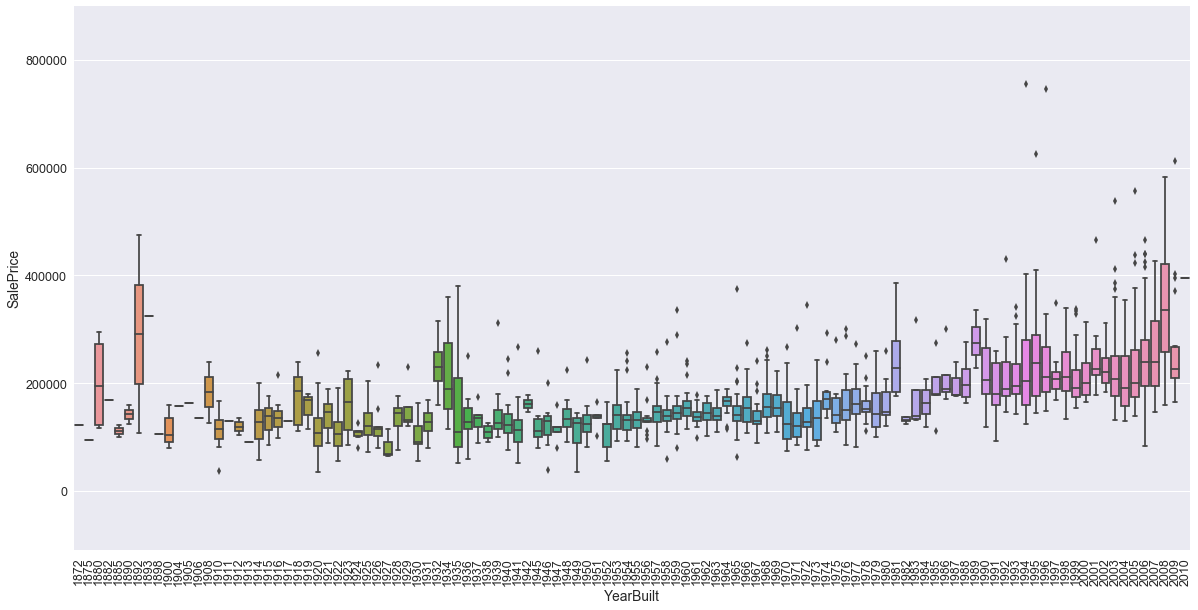

In [49]:
fig = plt.figure(figsize=(20,10))
sns.boxplot(df['YearBuilt'], df['SalePrice'], data=df)
plt.margins(0.2)
plt.xticks(rotation=90)
plt.show()

In [59]:
features['NewerHome'] = np.where(df['YearBuilt'] >= 2000, 1, 0)

In [60]:
features.describe()

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,Garage,SquareFootage,BsmtQual,newer_home,NewerHome
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1460.000000,1460.000000
mean,1.362685e-16,1.387018e-16,-1.277517e-16,-3.504046e-16,-2.445532e-16,1.216683e-16,1.545187e-16,-5.353404e-17,0.265753,0.265753
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,9.538160e-01,1.000343e+00,0.441885,0.441885
min,-1.838704e+00,-3.688413e+00,-2.249120e+00,-2.431510e+00,-2.278176e+00,-2.365440e+00,-2.276889e+00,-3.982114e+00,0.000000,0.000000
25%,-6.415162e-01,-7.951515e-01,-7.347485e-01,-6.896039e-01,-7.710908e-01,-1.026858e+00,-6.456183e-01,-5.581526e-01,0.000000,0.000000
50%,-2.256643e-01,-7.183611e-02,-9.797004e-02,-6.896039e-01,-7.710908e-01,3.117246e-01,-1.882398e-01,5.831678e-01,0.000000,0.000000
75%,4.165294e-01,6.514792e-01,4.974036e-01,1.052302e+00,7.359943e-01,3.117246e-01,5.447684e-01,5.831678e-01,1.000000,1.000000
max,7.228819e+00,2.821425e+00,7.855574e+00,2.794208e+00,2.243080e+00,2.988889e+00,1.032328e+01,1.724488e+00,1.000000,1.000000


In [61]:
features.head()

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,Garage,SquareFootage,BsmtQual,newer_home,NewerHome
0,0.347273,0.651479,0.370333,1.052302,0.735994,0.311725,-0.626154,0.583168,1,1
1,0.007288,-0.071836,-0.482512,-0.689604,-0.771091,0.311725,0.361679,0.583168,0,0
2,0.536154,0.651479,0.515013,1.052302,0.735994,0.311725,-0.470436,0.583168,1,1
3,-0.515281,0.651479,0.383659,-0.689604,0.735994,1.650307,-0.604322,-0.558153,0,0
4,0.869843,1.374795,1.299326,1.052302,0.735994,1.650307,0.077008,0.583168,1,1


LogPrice         1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea        0.700927
Garage           0.680625
ExterQual        0.678840
KitchenQual      0.667893
SquareFootage    0.633831
BsmtQual         0.615804
NewerHome        0.488415
Name: LogPrice, dtype: float64


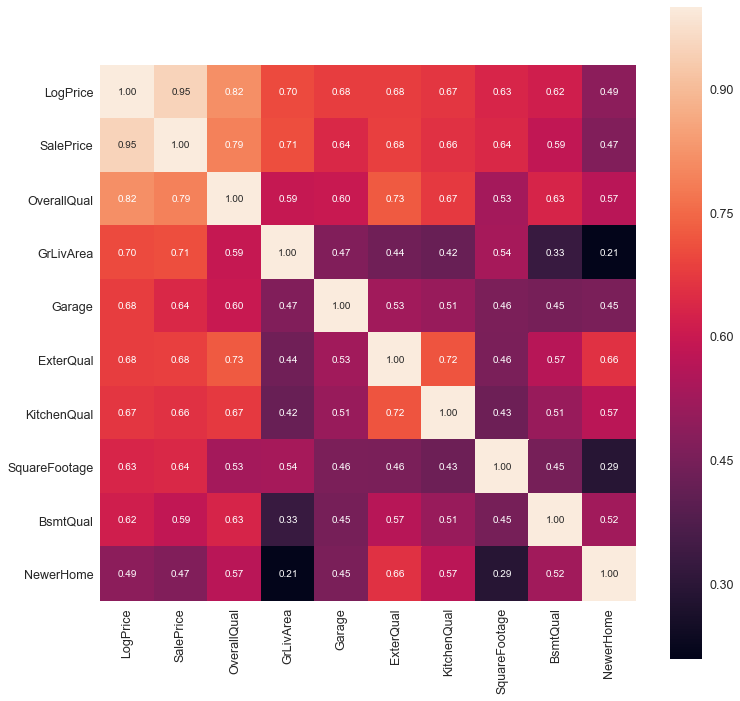

In [66]:
corrmat = features.corr()
target = 'LogPrice'
nr_cols = 15
print (corrmat.nlargest(nr_cols, target)[target])

cols = corrmat.nlargest(nr_cols, target)[target].index
cm = np.corrcoef(features[cols].values.T)

plt.figure(figsize=(12,12))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature Selection through Filter Method

Based on the above correlation matrix, we will whittle down our feature set from 10 to 5. 
The top 5 features based on correlation to target variable are:
    
    {'OverallQual': 0.82, 'GrLivArea': 0.70, 'Garage': 0.68, 'ExterQual': 0.68, and 
    'KitchenQual': 0.67}